<a href="https://colab.research.google.com/github/NataliaKolesnik/Car_Price_prediction_part2/blob/master/4_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install lightautoml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 322 kB 4.5 MB/s 
     |████████████████████████████████| 25.9 MB 2.3 MB/s 
     |████████████████████████████████| 425 kB 74.9 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 804.1 MB 2.1 kB/s 
     |████████████████████████████████| 215 kB 53.8 MB/s 
     |████████████████████████████████| 1.2 MB 61.1 MB/s 
     |████████████████████████████████| 9.5 MB 56.4 MB/s 
     |████████████████████████████████| 308 kB 76.2 MB/s 
     |████████████████████████████████| 2.8 MB 43.8 MB/s 
     |████████████████████████████████| 209 kB 44.3 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 112 kB 54.5 MB/s 
     |██████████████████████████████

In [ ]:
path_data = '/content/drive/MyDrive/SF_project_8/data/'

##Библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

SEED = 42
np.random.seed(SEED)


## Загрузка и подготовка данных для обучения

In [ ]:
df_train = pd.read_csv(path_data+'train_for_ML.csv')
df_test = pd.read_csv(path_data+'test_for_ML.csv')

In [ ]:
# Списки с признаками

categorical_features = ['bodyType', 'brand', 'model_info', 'brand_model', 'color_littel', 
                          'fuelType_littel', 'vehicleTransmission', 'Привод' ]

numerical_features = ['engineDisplacement', 'enginePower', 'enginePower_log', 'mileage', 'mileage_стоп_q99',
                        'age_avto_стоп_23', 'mileage_/_age_avto', 'Владельцы', 
                        'numberOfDoors', 'xDrive', 'ПТС_10']

target = 'price'
target_log = 'price_log'

In [ ]:
# Соберем датасеты

X = df_train[categorical_features + numerical_features]

X_test = df_test[categorical_features + numerical_features]

Y = df_train[target]
Y_log = df_train[target_log]

In [ ]:
# Стандартизируем числовые данные

scaler = MinMaxScaler()

X[numerical_features] = scaler.fit_transform(X[numerical_features])
X_test[numerical_features] = scaler.fit_transform(X_test[numerical_features])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [ ]:
X.describe()

,engineDisplacement,enginePower,enginePower_log,mileage,mileage_стоп_q99,age_avto_стоп_23,mileage_/_age_avto,Владельцы,numberOfDoors,xDrive,ПТС_10
count,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00
mean,0.42,0.32,0.54,0.12,0.33,0.36,0.17,0.55,0.76,0.11,0.89
std,0.16,0.19,0.18,0.08,0.22,0.22,0.09,0.42,0.29,0.32,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.19,0.42,0.06,0.16,0.18,0.12,0.00,0.67,0.00,1.00
50%,0.42,0.28,0.53,0.11,0.31,0.32,0.17,0.50,0.67,0.00,1.00
75%,0.45,0.41,0.66,0.17,0.47,0.50,0.22,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
X_test.describe()

,engineDisplacement,enginePower,enginePower_log,mileage,mileage_стоп_q99,age_avto_стоп_23,mileage_/_age_avto,Владельцы,numberOfDoors,xDrive,ПТС_10
count,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00
mean,0.42,0.26,0.44,0.12,0.33,0.36,0.23,0.55,0.75,0.11,0.90
std,0.16,0.18,0.19,0.08,0.22,0.23,0.12,0.41,0.30,0.31,0.30
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.14,0.31,0.06,0.16,0.18,0.15,0.00,0.67,0.00,1.00
50%,0.41,0.22,0.43,0.11,0.30,0.32,0.22,0.50,0.67,0.00,1.00
75%,0.45,0.34,0.57,0.17,0.46,0.50,0.29,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# Закодируем категориальные переменные (так как в тестовой выборки есть такие модели авто, которые отсутсвуют в тренировочной, то для кодирования датасеты придется объединить) 

X['sample'] = 1
X_test['sample'] = 0

X_join = pd.concat([X, X_test])

X_join = pd.get_dummies(X_join, columns=categorical_features)

X = X_join[X_join['sample'] == 1].drop(['sample'], axis=1)
X_test = X_join[X_join['sample'] == 0].drop(['sample'], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Разбиваем на обучающую и валидационную выборки

X_train = pd.concat([Y, X], axis=1)
X_train_log = pd.concat([Y_log, X], axis=1)

# X_train, X_valid = train_test_split(X, test_size=0.2, random_state=SEED, shuffle=True)
# X_train_log, X_valid_log = train_test_split(X_log, test_size=0.2, random_state=SEED, shuffle=True)

## Обучение модели

In [ ]:
# определяем задачу

task = Task('reg', loss='rmsle', metric='mae')

In [ ]:
# определяем роли

roles = {
    'target' : 'price_log',
    #'categorical': categorical_features
}

In [ ]:
# создаем модель
automl_1 = TabularAutoML(
    task=task,
    timeout=60*60,
    general_params = {
        'use_algos': [['linear_l2', 'lgb', 'cb'], ['lgb_tuned', 'cb_tuned'] ]
        },
    reader_params={
        'cv': 10,
        'random_state': SEED,
        'verbose': 1
    }
)

In [ ]:
oof_pred_1 = automl_1.fit_predict(X_train_log, roles=roles, verbose=1)

[01:40:40] Stdout logging level is INFO.
[01:40:40] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[01:40:40] Task: reg

[01:40:40] Start automl preset with listed constraints:
[01:40:40] - time: 3600.00 seconds
[01:40:40] - CPU: 4 cores
[01:40:40] - memory: 16 GB

[01:40:40] Train data shape: (6682, 285)

[01:40:47] Layer 1 train process start. Time left 3593.19 secs
[01:40:48] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[01:40:55] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.1721823352969203
[01:40:55] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[01:40:55] Time left 3585.19 secs

[01:40:59] Selector_LightGBM fitting and predicting completed
[01:41:00] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[01:41:49] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.14059595917477302
[01:41:49] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[01:41:49] Start fitting Lvl_0_Pipe_1_Mod_1_CatBoos

In [ ]:
# Структура модели
print(automl_1.create_model_str_desc())

Models on level 0:
	 10 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 10 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 10 averaged models Lvl_0_Pipe_1_Mod_1_CatBoost

Final prediction for new objects (level 1) = 
	 0.13173 * (10 averaged models Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM) +
	 0.86827 * (10 averaged models Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost) 


In [ ]:
oof_pred_exp = np.exp(oof_pred_1.data[:, 0])

mean_absolute_percentage_error(np.exp(X_train_log['price_log']), oof_pred_exp)

0.11916327349811232

In [ ]:
oof_pred_exp = np.exp(oof_pred_1.data[:, 0])

mean_absolute_percentage_error(np.exp(X_train_log['price_log']), oof_pred_exp)

0.11916327349811232

### Важность признаков

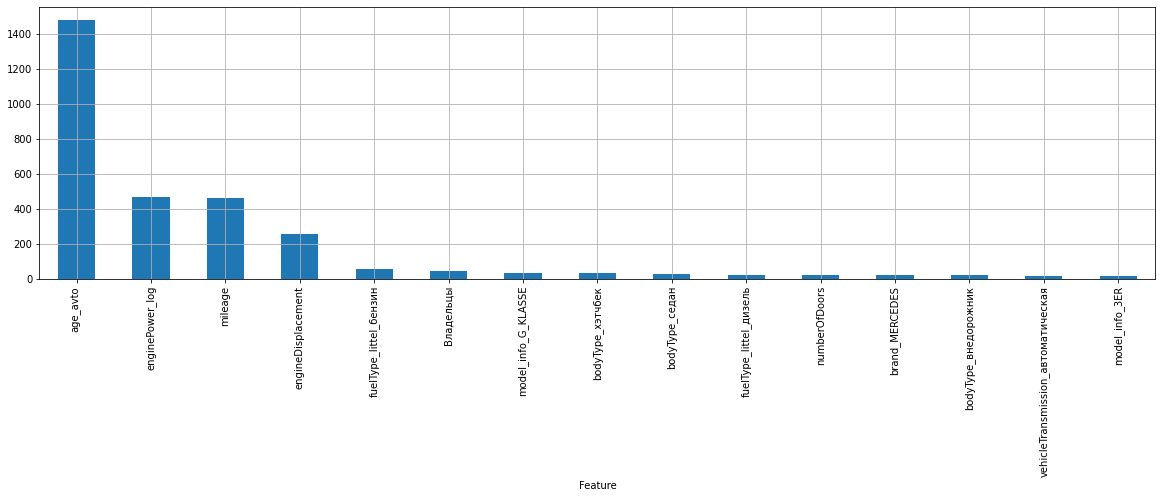

In [ ]:
fast_fi_1 = automl_1.get_feature_scores('fast')
fast_fi_1[:15].set_index('Feature')['Importance'].plot.bar(figsize=(20, 5), grid=True)

In [ ]:
# создаем модель
automl_2 = TabularUtilizedAutoML(
    task=task,
    timeout=60*60,
    general_params = {
        'use_algos': [['linear_l2', 'lgb', 'cb'], ['lgb_tuned', 'cb_tuned'], ]
        },
    reader_params={
        'cv': 10,
        'random_state': SEED,
        'verbose': 1
    }
)

In [ ]:
oof_pred_2 = automl_2.fit_predict(X_train_log, roles=roles, verbose=1)

[01:56:13] Start automl utilizator with listed constraints:
[01:56:13] - time: 3600.00 seconds
[01:56:14] - CPU: 4 cores
[01:56:14] - memory: 16 GB

[01:56:14] If one preset completes earlier, next preset configuration will be started

[01:56:14] ==================================================
[01:56:14] Start 0 automl preset configuration:
[01:56:14] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[01:56:14] Stdout logging level is INFO.
[01:56:14] Task: reg

[01:56:14] Start automl preset with listed constraints:
[01:56:14] - time: 3599.99 seconds
[01:56:14] - CPU: 4 cores
[01:56:14] - memory: 16 GB

[01:56:14] Train data shape: (6682, 285)

[01:56:20] Layer 1 train process start. Time left 3593.91 secs
[01:56:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[01:56:23] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.1721823352969203
[01:56:23] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predict

In [ ]:
# Структура модели
print(automl_2.create_model_str_desc())


Final prediction for new objects = 
	0.23194 * 1 averaged models with config = "conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 10 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 10 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 10 averaged models Lvl_0_Pipe_1_Mod_1_CatBoost

		Final prediction for new objects (level 1) = 
			 0.69292 * (10 averaged models Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM) +
			 0.30708 * (10 averaged models Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost) 


	+ 0.23287 * 1 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 10 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 10 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 10 averaged models Lvl_0_Pipe_1_Mod_1_CatBoost

		Final prediction for new objects (level 1) = 
			 0.37041 * (10 averaged models Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM) +
			 0.62959 * (10 averaged models 

In [ ]:
oof_pred_exp_2 = np.exp(oof_pred_2.data[:, 0])

mean_absolute_percentage_error(np.exp(X_train_log['price_log']), oof_pred_exp_2)

0.11400192297401389

In [ ]:
oof_pred_exp_2 = np.exp(oof_pred_2.data[:, 0])

mean_absolute_percentage_error(np.exp(X_train_log['price_log']), oof_pred_exp_2)

0.11478351257796071

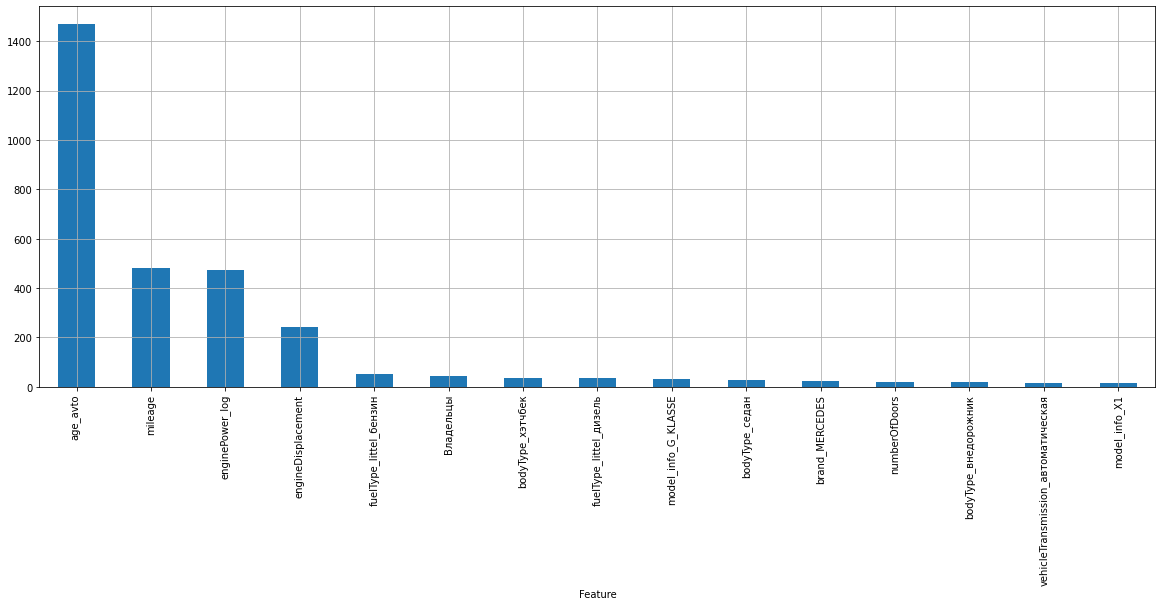

In [ ]:
fast_fi_2 = automl_2.get_feature_scores('fast')
fast_fi_2[:15].set_index('Feature')['Importance'].plot.bar(figsize=(20, 7), grid=True)

## Предсказание

In [ ]:
# предсказываем результат 
y_test_predict = automl_2.predict(X_test)

In [ ]:
y_test_predict.data[:,0]

array([13.252276, 14.76549 , 13.386295, ..., 14.14925 , 13.807446,
       13.858031], dtype=float32)

In [ ]:
y_test_predict = np.exp(y_test_predict.data[:,0])

In [ ]:
submission = pd.read_csv(path_data+'sample_submission.csv')
submission['price'] = y_test_predict
submission.to_csv(path_data+'sample_submission_AutoML.csv', index=False)

In [ ]:
submission

,sell_id,price
0,1099427284,569364.69
1,1096405886,2585655.50
2,1100195294,651019.81
3,1099827282,493196.28
4,1100076198,2375180.50
...,...,...
1666,1099414488,895362.25
1667,1099277058,2381190.75
1668,1098773964,1396179.38
1669,1098835932,991967.38


In [ ]:
submission

,sell_id,price
0,1099427284,589983.81
1,1096405886,2680391.75
2,1100195294,686300.38
3,1099827282,521176.03
4,1100076198,2579869.75
...,...,...
1666,1099414488,964937.38
1667,1099277058,2385286.25
1668,1098773964,1452259.38
1669,1098835932,1035648.31


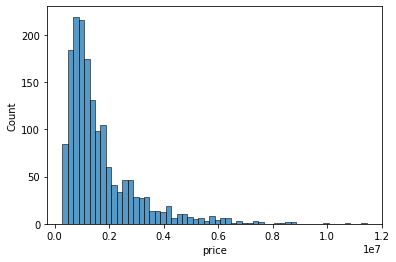

In [ ]:
sns.histplot(submission['price'])